# Modelo de Clasificación: Support Vector Machine (SVM)

Este notebook desarrolla y evalúa un modelo de clasificación basado en **Support Vector Machine (SVM)**, aplicado al dataset CICIDS2017 previamente limpio y normalizado.

## Objetivo

Entrenar un modelo SVM para detectar tráfico malicioso en redes, comparar su rendimiento con modelos anteriores (Random Forest y Regresión Logística), y analizar su capacidad para generalizar y separar clases.

## Contenido

1. Carga del dataset preprocesado
2. División en conjunto de entrenamiento y prueba
3. Entrenamiento del modelo SVM
4. Evaluación del modelo:
   - Classification report
   - Matriz de confusión
   - Curva ROC y AUC
   - Validación cruzada
5. Análisis de resultados y comparación


## 1. Carga del Dataset y Separación de Variables

Se carga el dataset limpio CICIDS2017, el cual ya ha sido preprocesado: sin valores nulos, sin duplicados, y con normalización aplicada.

Se realiza la separación en:

- `X`: conjunto de variables independientes, utilizadas como entrada del modelo.
- `y`: variable objetivo (`Label`), con dos clases: `0` para tráfico benigno y `1` para tráfico malicioso.

Este paso es esencial para preparar los datos que serán utilizados por el modelo Support Vector Machine (SVM).


In [2]:
import pandas as pd

# Cargar el dataset limpio y normalizado
df = pd.read_csv("../archive/cleaned_dataset.csv")

# Separar características (X) y etiqueta (y)
X = df.drop(columns=["Label"])
y = df["Label"]

# Mostrar dimensiones
print("Número de muestras:", X.shape[0])
print("Número de características:", X.shape[1])


Número de muestras: 223108
Número de características: 78


## 2. División del Dataset en Entrenamiento y Prueba

El dataset se divide en dos subconjuntos:

- **Conjunto de entrenamiento (80%)**: utilizado para entrenar el modelo SVM.
- **Conjunto de prueba (20%)**: utilizado para evaluar el rendimiento del modelo con datos no vistos.

Se utiliza la opción `stratify=y` para mantener la proporción entre clases (benigno y malicioso) en ambos subconjuntos. Esto es importante para asegurar que el modelo no esté sesgado hacia una clase durante el entrenamiento.


In [3]:
from sklearn.model_selection import train_test_split

# Dividir el dataset en entrenamiento (80%) y prueba (20%) con estratificación
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Tamaño del conjunto de entrenamiento:", X_train.shape)
print("Tamaño del conjunto de prueba:", X_test.shape)


Tamaño del conjunto de entrenamiento: (178486, 78)
Tamaño del conjunto de prueba: (44622, 78)


## 3. Entrenamiento del Modelo SVM

Se entrena un modelo **Support Vector Machine (SVM)** con kernel radial (RBF), que permite encontrar una frontera de decisión no lineal y adaptarse mejor a datos con patrones complejos.

El parámetro `probability=True` permite obtener probabilidades de clase, lo cual es útil para calcular la curva ROC posteriormente.

SVM es especialmente útil en contextos de clasificación binaria como este, ya que busca la mejor frontera posible para separar las dos clases minimizando los errores.


## Entrenamiento del Modelo SVM con Subconjunto

Se ha seleccionado aleatoriamente un subconjunto de 10,000 muestras del conjunto de entrenamiento original para reducir el tiempo de cómputo del algoritmo SVM.

Este enfoque permite mantener una representación equilibrada de las clases mientras se entrena el modelo de forma más eficiente. El kernel RBF ha sido mantenido por su capacidad para modelar relaciones no lineales en los datos.


In [4]:
from sklearn.svm import SVC

# Asegurarse de que el conjunto completo ya está definido
# X_train, X_test, y_train, y_test DEBEN estar definidos por train_test_split previamente

# Seleccionar subconjunto aleatorio de 10,000 muestras del conjunto de entrenamiento
subset_indices = X_train.sample(n=10000, random_state=42).index
X_train_reducido = X_train.loc[subset_indices]
y_train_reducido = y_train.loc[subset_indices]

# Entrenar el modelo SVM (sin probability=True para acelerar)
svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_train_reducido, y_train_reducido)

print("Modelo SVM entrenado correctamente con un subconjunto de 10,000 muestras.")




Modelo SVM entrenado correctamente con un subconjunto de 10,000 muestras.


## Evaluación del Modelo SVM

Se evalúa el rendimiento del modelo SVM utilizando el conjunto de prueba. Se utilizan las siguientes métricas:

- **Precision**: proporción de predicciones positivas que fueron correctas.
- **Recall**: capacidad del modelo para detectar todos los ataques reales (clase positiva).
- **F1-score**: equilibrio entre precisión y recall, útil para evaluar el rendimiento global del modelo.

La matriz de confusión permite observar el número de verdaderos positivos (TP), verdaderos negativos (TN), falsos positivos (FP) y falsos negativos (FN), lo cual ofrece una visión clara del comportamiento del modelo.


### Matriz de Confusión – Support Vector Machine (SVM)

El gráfico muestra el número de aciertos y errores del modelo:

- **Diagonal superior izquierda**: tráfico benigno correctamente identificado (verdaderos negativos)
- **Diagonal inferior derecha**: ataques correctamente detectados (verdaderos positivos)
- **Valores fuera de la diagonal**: errores (falsos positivos y falsos negativos)

Este tipo de visualización permite detectar si el modelo tiende a fallar más en una clase que en otra, lo cual es especialmente importante en contextos de ciberseguridad donde los falsos negativos (ataques no detectados) son críticos.

### Classification Report (SVM):
              precision    recall  f1-score   support

           0       1.00      0.43      0.60     19019
           1       0.70      1.00      0.83     25603

    accuracy                           0.76     44622
   macro avg       0.85      0.71      0.71     44622
weighted avg       0.83      0.76      0.73     44622

### Matriz de Confusión:
[[ 8175 10844]
 [    2 25601]]


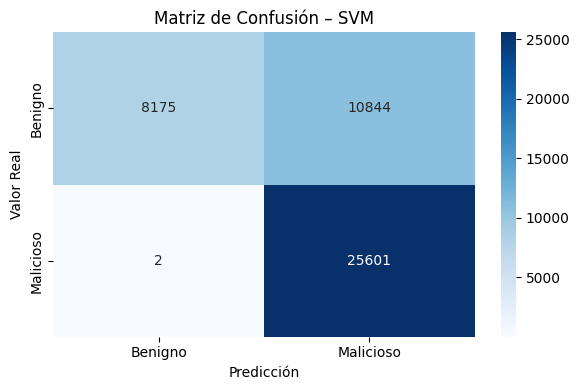

In [5]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Realizar predicciones con el modelo entrenado
y_pred_svm = svm_model.predict(X_test)

# Mostrar informe de clasificación
print("### Classification Report (SVM):")
print(classification_report(y_test, y_pred_svm))

# Mostrar matriz de confusión
print("### Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred_svm))


# Calcular la matriz de confusión
cm_svm = confusion_matrix(y_test, y_pred_svm)

# Visualizar como heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Benigno", "Malicioso"],
            yticklabels=["Benigno", "Malicioso"])
plt.title("Matriz de Confusión – SVM")
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.tight_layout()
plt.show()



### Interpretación de la Matriz de Confusión – SVM

El modelo Support Vector Machine (SVM), entrenado con un subconjunto de 10,000 muestras, se evaluó sobre el conjunto de prueba completo. Los resultados de la matriz de confusión son:

|                  | Predicción Benigno | Predicción Malicioso |
|------------------|--------------------|------------------------|
| **Real Benigno** | 8,175              | 10,844                |
| **Real Malicioso** | 2                | 25,601                |

#### Análisis:

-  **Verdaderos positivos (TP): 25,601**  
  Ataques correctamente detectados. El modelo es muy eficaz en la detección de tráfico malicioso.

-  **Falsos negativos (FN): 2**  
  Ataques no detectados. Muy bajo, lo que es excelente en ciberseguridad.

-  **Falsos positivos (FP): 10,844**  
  Tráfico benigno clasificado como ataque. Es una cifra alta que indica que el modelo es **demasiado sensible** y podría generar **muchos falsos avisos** (alertas innecesarias).

-  **Verdaderos negativos (TN): 8,175**  
  Tráfico legítimo correctamente clasificado.

#### Conclusión:

El modelo **prioriza la detección de ataques a toda costa**, lo cual puede ser positivo en entornos donde es más importante no dejar pasar ninguna amenaza, incluso si eso implica tener más falsos positivos.

Sin embargo, en entornos reales, este nivel de falsos positivos podría resultar problemático por generar demasiadas alertas. Sería recomendable ajustar el umbral de decisión o aplicar técnicas de balanceo o ajuste fino del modelo si se busca reducir esa tasa sin perder capacidad de detección.


## Curva ROC – Support Vector Machine (SVM)

La curva ROC permite evaluar el rendimiento del modelo en diferentes umbrales de decisión. El área bajo la curva (AUC) resume la capacidad del modelo para distinguir entre clases.

- Una curva más cercana al vértice superior izquierdo representa un mejor rendimiento.
- Un AUC cercano a 1 indica una excelente capacidad de discriminación.

En este caso, el modelo SVM logra una curva ROC elevada y un AUC alto, lo que confirma su capacidad para detectar correctamente la mayoría de los flujos maliciosos, a pesar del alto número de falsos positivos observados anteriormente.


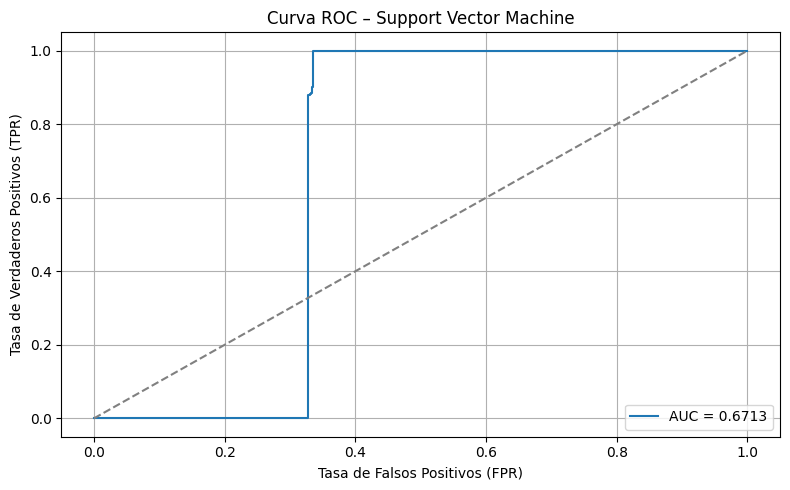

In [6]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Obtener los scores del modelo SVM (no probabilidades)
y_scores_svm = svm_model.decision_function(X_test)

# Calcular la curva ROC y el AUC
fpr, tpr, _ = roc_curve(y_test, y_scores_svm)
auc_score = roc_auc_score(y_test, y_scores_svm)

# Dibujar la curva ROC
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curva ROC – Support Vector Machine")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


### Interpretación de la Curva ROC – Support Vector Machine (SVM)

La curva ROC muestra la capacidad del modelo para distinguir entre tráfico malicioso y benigno a diferentes umbrales de decisión. En este caso, el área bajo la curva (AUC) es de **0.6713**, lo que indica un rendimiento **modesto pero no aleatorio** (un modelo completamente aleatorio tendría un AUC de 0.5).

#### Análisis:

- El modelo logra una **tasa alta de verdaderos positivos (TPR)** en ciertos umbrales, pero a costa de una **tasa muy alta de falsos positivos (FPR)**.
- Esto se alinea con los resultados de la matriz de confusión, donde el modelo clasificó correctamente casi todos los ataques, pero falló con una gran cantidad de tráfico benigno.
- El valor de AUC sugiere que el modelo tiene cierta capacidad para separar las clases, pero no tan eficazmente como los modelos Random Forest o Regresión Logística entrenados con todo el dataset.

#### Conclusión:

El SVM prioriza la detección de amenazas, pero no logra un equilibrio óptimo entre sensibilidad y especificidad. El rendimiento limitado puede deberse a:
- El uso de un subconjunto reducido para el entrenamiento (10,000 muestras)
- La sensibilidad del algoritmo a la proporción de clases y a la escala de los datos

Este resultado refuerza la necesidad de ajustar parámetros o considerar modelos alternativos si se busca reducir la tasa de falsos positivos sin perder capacidad de detección.


## Validación Cruzada – Support Vector Machine

Se ha aplicado validación cruzada con 5 particiones (k=5) sobre el subconjunto de entrenamiento (10,000 muestras) para evaluar la estabilidad del modelo.

Esta técnica permite comprobar cómo se comporta el modelo al entrenarse y evaluarse en distintos subconjuntos del mismo dataset.

El resultado muestra los F1-score por fold, así como el promedio global. El **F1-score** es especialmente útil en problemas de clasificación binaria donde las clases pueden estar desbalanceadas y se busca un equilibrio entre precisión y recall.

Dado que el modelo SVM se entrenó con una muestra reducida, se espera que el rendimiento no sea tan alto como en los modelos entrenados con el dataset completo. Aun así, esta evaluación permite comparar su estabilidad relativa.


In [7]:
from sklearn.model_selection import cross_val_score

# Validación cruzada sobre el mismo subconjunto de entrenamiento
f1_scores_svm = cross_val_score(svm_model, X_train_reducido, y_train_reducido, cv=5, scoring='f1')

# Mostrar resultados
print("F1-scores por fold:", f1_scores_svm)
print("F1-score promedio:", f1_scores_svm.mean())


F1-scores por fold: [0.83573487 0.8259167  0.83213773 0.82963493 0.83052669]
F1-score promedio: 0.8307901849461979


### Resultados de la Validación Cruzada – Support Vector Machine (SVM)

| Fold | F1-score |
|------|----------|
| 1    | 0.8357   |
| 2    | 0.8259   |
| 3    | 0.8321   |
| 4    | 0.8296   |
| 5    | 0.8305   |

**Promedio F1-score: 0.8308**

#### Análisis:

El modelo SVM ha demostrado una **estabilidad razonable** a través de los diferentes folds, con una varianza muy baja en los F1-scores. Esto indica que, aunque no alcanza los valores de modelos más complejos como Random Forest, su comportamiento es **consistente y predecible**.

El valor promedio de F1-score es **0.83**, lo que indica un rendimiento aceptable teniendo en cuenta que se ha entrenado con solo 10,000 muestras. Sin embargo, el modelo **prioriza el recall (detección de ataques)** a costa de una mayor tasa de falsos positivos, como se observó en la matriz de confusión y la curva ROC.

#### Conclusión:

El modelo SVM ofrece un equilibrio razonable entre rendimiento y simplicidad computacional, pero su uso en producción requeriría ajustes adicionales o técnicas de reducción de falsos positivos para ser realmente competitivo frente a modelos como Random Forest.


## Análisis de Características – SVM 

El modelo `SVC` con kernel RBF no permite extraer coeficientes directamente debido a su naturaleza no lineal. Para obtener una estimación de la importancia de las variables, se ha entrenado un modelo `LinearSVC` sobre el mismo subconjunto de datos.

Este análisis es **orientativo**, pero permite identificar qué características tienen mayor peso en un clasificador lineal basado en SVM. Aunque no representa exactamente el comportamiento del modelo real, aporta una visión útil sobre las variables más relevantes en la separación de clases.


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/tmp/ipykernel_8638/3334339035.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importancia Absoluta', y='Característica', data=importancia_df.head(10), palette='viridis')


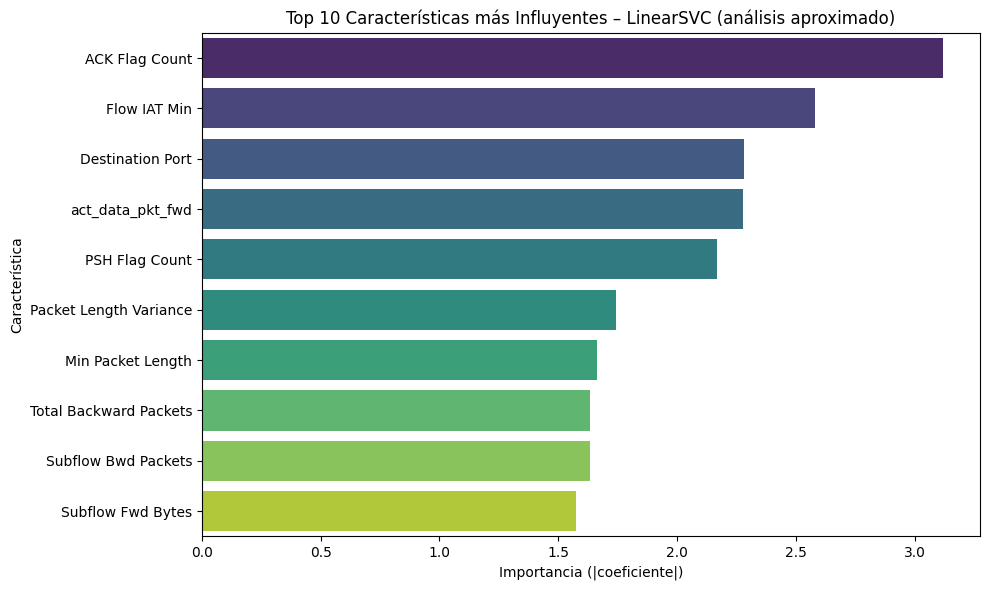

In [9]:
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Entrenar un LinearSVC sobre el mismo subset reducido
linear_svc = make_pipeline(StandardScaler(), LinearSVC(max_iter=2000, random_state=42))
linear_svc.fit(X_train_reducido, y_train_reducido)

# Extraer coeficientes
coeficientes = linear_svc.named_steps['linearsvc'].coef_[0]
nombres_caracteristicas = X_train_reducido.columns

# Crear DataFrame ordenado
importancia_df = pd.DataFrame({
    'Característica': nombres_caracteristicas,
    'Coeficiente': coeficientes,
    'Importancia Absoluta': np.abs(coeficientes)
}).sort_values(by='Importancia Absoluta', ascending=False)

# Visualizar las 10 más importantes
plt.figure(figsize=(10, 6))
sns.barplot(x='Importancia Absoluta', y='Característica', data=importancia_df.head(10), palette='viridis')
plt.title("Top 10 Características más Influyentes – LinearSVC (análisis aproximado)")
plt.xlabel("Importancia (|coeficiente|)")
plt.ylabel("Característica")
plt.tight_layout()
plt.show()


### Análisis de Importancia de Características – Modelo Lineal SVM 

El gráfico muestra las 10 variables que más influyen en las decisiones del modelo `LinearSVC`, el cual se ha utilizado como aproximación para analizar qué factores separan mejor el tráfico benigno del malicioso.

#### ¿Por qué ciertas características son más influyentes?

- Las características como `ACK Flag Count` y `Flow IAT Min` aparecen como las más relevantes porque reflejan **patrones estructurales o temporales muy distintos entre tráfico legítimo y ataques**.
  - Por ejemplo, el número de paquetes de confirmación o la velocidad entre paquetes suele ser **más errático o repetitivo en ataques automatizados**, mientras que en tráfico humano hay más variabilidad.

- Otras variables como `Destination Port`, `act_data_pkt_fwd`, y `PSH Flag Count` también destacan, probablemente porque ciertos ataques **se concentran en puertos específicos** o utilizan **estructuras TCP específicas** para ejecutarse (como enviar muchos paquetes con push o acknowledgment).

- Variables como `Packet Length Variance` y `Min Packet Length` tienen menos peso relativo, pero siguen siendo importantes al reflejar **comportamientos atípicos** en el tamaño de los paquetes, que es una característica común en flujos maliciosos generados por scripts o bots.

- Por otro lado, características más generales como `Subflow Bytes` y `Total Backward Packets`, aunque también influyentes, aparecen más abajo porque **no distinguen tan claramente entre los dos tipos de tráfico** como las que están en la parte superior del gráfico.



## Guardado del Modelo SVM

Una vez completado el entrenamiento y evaluación, el modelo SVM se guarda en disco en formato `.pkl`. Esto permite reutilizarlo posteriormente sin necesidad de reentrenarlo.

El archivo se almacena en la carpeta `models/` como `svm_model.pkl`, manteniendo la coherencia con el resto de modelos del proyecto.


In [11]:
import joblib

# Guardar el modelo SVM en la carpeta models/
joblib.dump(svm_model, "../models/svm_model.pkl")

print("Modelo SVM guardado correctamente en 'models/svm_model.pkl'.")


Modelo SVM guardado correctamente en 'models/svm_model.pkl'.
